# Before you start

Before you review this notebook, please spend an hour or two on your own familiarizing yourself with the data, thinking about the problem, and the approach you would like to take.  If you just jump into the starter code, you will miss out on your own creative thinking, and limit yourself to what you see here.   

***

**First, some library imports**

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE 
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, plot_confusion_matrix, ConfusionMatrixDisplay


# Complaints dataset from CFPB  
## Load the data  
First, we load the dataset.  We use the file in the `shared\` folder.

In [2]:
# To load the data directly from the CFPB website, use the below command.  Be aware you will get lots of data!
# You will then need to filter it for just the 5 banks we are interested in analyzing.
# complaints = pd.read_csv(r'https://files.consumerfinance.gov/ccdb/complaints.csv.zip')

In [ ]:
# Load dataset from provided file.  Be sure to use the correct path.

complaints = pd.read_csv('complaints_25Nov21.csv')

# complaints = pd.read_csv('shared/complaints_25Nov21.csv')

## Review the data
The next few cells look at the data in a couple of different ways.  This does not cover graphing and visualization, but you should do that.

In [ ]:
# How many rows and columns do we have?

complaints.shape

In [ ]:
# What are the column names?

complaints.columns

In [ ]:
# Let us look at which banks have the most number of complaints

complaints['Company'].value_counts().sort_values(ascending=False)

In [ ]:
# Because the data is already pre-filtered to the top-5 companies, we do not need to run the below commands.
# But if you are using the file directly from the CFPB website, you will need to do this as we want to analyze
# only the top-5 banks.

# banks = ['BANK OF AMERICA, NATIONAL ASSOCIATION', 'WELLS FARGO & COMPANY','JPMORGAN CHASE & CO.', 'CITIBANK, N.A.' , 'U.S. BANCORP']
# filtered = complaints[(complaints['Company'].isin(banks))]
# filtered.to_csv("complaints_14Nov21.csv", index=False)

In [ ]:
# Let us get a feel for the data

complaints

## Predicting 'Consumer Disputed'

We look at the distribution of how many people disputed the complaint's resolution versus how many did not.  

In [ ]:
complaints['Consumer disputed?'].value_counts()

In [ ]:
# Let us see how many total disputes are there

complaints['Consumer disputed?'].value_counts().sum()

**The above is 207,260 records.  Which is the same as the number of records in our dataset.  That means we do not have any `NaN` values.**

In [ ]:
# Check for NaNs in the 'Consumer Disputed' column

complaints['Consumer disputed?'].isna().sum()

In [ ]:
# Next, for cleanliness we change the column type for 'Consumer Disputed' from string to category
# We don't have to do this, but can't hurt just in case an algorithm we are trying needs this.

complaints['Consumer disputed?'] = complaints['Consumer disputed?'].astype('category')

Now let us look at our split between disputed and not-disputed complaints.

In [ ]:
complaints['Consumer disputed?'].value_counts()

In [ ]:
# same thing as a percentage...
complaints['Consumer disputed?'].value_counts() / (complaints['Consumer disputed?'].value_counts().sum())

So we have an imbalanced dataset as only about 12% is in the `Yes` class.  This means we should consider rebalancing the training dataset using a technique such as SMOTE.  But we will do that after doing the train-test split.  But first, we need to think about what in our data should be the predictor variables, ie, what should be included as a feature in `X`.

## Deciding the feature set      
To do that, let us look at the dataset again.  And refer to the data-dictionary in the Word document for the project.  

|Field name  |Description  |Can it be a feature?  |
|------------  |------------  |------------  |
|Date received  |The date the CFPB received the complaint. For example, “05/25/2013.”  |Not a feature  |
|Product  |The type of product the consumer identified in the complaint. For example, “Checking or savings account” or “Student loan.”  |Yes  |
|Sub-product  |The type of sub-product the consumer identified in the complaint. For example, “Checking account” or “Private student loan.”  |Yes  |
|Issue  |The issue the consumer identified in the complaint. For example, “Managing an account” or “Struggling to repay your loan.”  |Yes  |
|Sub-issue  |The sub-issue the consumer identified in the complaint. For example, “Deposits and withdrawals” or “Problem lowering your monthly payments.”  |Yes  |
|Consumer complaint narrative  |Consumer complaint narrative is the consumer-submitted description of “what happened” from the complaint. Consumers must opt-in to share their narrative. We will not publish the narrative unless the consumer consents, and consumers can opt-out at any time. The CFPB takes reasonable steps to scrub personal information from each complaint that could be used to identify the consumer.  |Maybe, if we can convert text to some vector form  |
|Company public response  |The company’s optional, public-facing response to a consumer’s complaint. Companies can choose to select a response from a pre-set list of options that will be posted on the public database. For example, “Company believes complaint is the result of an isolated error.”  |Yes  |
|Company  |The complaint is about this company. For example, “ABC Bank.”  |Yes  |
|State  |The state of the mailing address provided by the consumer.  |Yes  |
|ZIP code  |The mailing ZIP code provided by the consumer. This field may: i) include the first five digits of a ZIP code; ii) include the first three digits of a ZIP code (if the consumer consented to publication of their complaint narrative); or iii) be blank (if ZIP codes have been submitted with non-numeric values, if there are less than 20,000 people in a given ZIP code, or if the complaint has an address outside of the United States).  |Yes  |
|Tags  |Data that supports easier searching and sorting of complaints submitted by or on behalf of consumers. For example, complaints where the submitter reports the age of the consumer as 62 years or older are tagged “Older American.” Complaints submitted by or on behalf of a servicemember or the spouse or dependent of a servicemember are tagged “Servicemember.” Servicemember includes anyone who is active duty, National Guard, or Reservist, as well as anyone who previously served and is a veteran or retiree.  |Yes  |
|Consumer consent provided?  |Identifies whether the consumer opted in to publish their complaint narrative. We do not publish the narrative unless the consumer consents, and consumers can opt-out at any time.  |Yes  |
|Submitted via  |How the complaint was submitted to the CFPB. For example, “Web” or “Phone.”  |Yes  |
|Date sent to company  |The date the CFPB sent the complaint to the company.  |Not relevant  |
|Company response to consumer  |This is how the company responded. For example, “Closed with explanation.”  |Yes  |
|Timely response?  |Whether the company gave a timely response. For example, “Yes” or “No.”  |Yes  |
|Consumer disputed?  |Whether the consumer disputed the company’s response.  |This the Target  |
|Complaint ID  |The unique identification number for a complaint.  |Not a feature  |


To begin with, let us ignore the text contained in 'Consumer complaint narrative' and look at the rest of the features.  We can come back to this later.

In [ ]:
X = complaints[[ 'Product', 'Sub-product', 'Issue', 'Sub-issue',
        'Company public response', 'Company',
       'State',  'Tags',
       'Submitted via',  'Company response to consumer',
       'Timely response?']]

In [ ]:
# Let us check if we have any missing values in our reduced dataset X

print(len(X)) # Number of rows before dropna()
print(len(X.dropna())) # Number of rows after dropna() 

If we were to drop `NaN` values, we would be left with very few rows.  That means we need to think harder about `NaN` values.  

To do that, let us look at which columns are missing values.  

In [ ]:
# Check how many values are missing in each column

X.isna().sum()

**Now the question is: how do we deal with these missing values?  Let us look at what each of these columns contain.  We will do a `unique()` on these columns to see which are the values contained in these columns.**  

In [ ]:
X['Sub-product'].unique()

In [ ]:
X['Sub-issue'].unique()

In [ ]:
X['State'].unique()

In [ ]:
X['Company public response'].unique()

In [ ]:
X['Tags'].unique()

## Dealing with missing data  
It is clear that all of these fields that have missing data are categorical, or string, and we cannot use any numerical imputation method to fill the missing values. 

What I would propose is to remove the NaNs by putting the text 'missing' in its place.  That would mean that all missing items would be treated as a category that we humans understand to be missing, but for the machine it is just another category called 'missing'.  

Of course, you are welcome to try other approaches.  

In [ ]:
X = X.fillna('missing')
X.dropna().shape

## Data prep
We see that there are no cells that have NAs any more after our operations above.  So it is safe to proceed.

In [ ]:
# Next, we convert all the X observations into numbers

X = pd.get_dummies(X)


In [ ]:
# Let us see what X looks like

print('X has the shape ',X.shape)

X

**Let us get our _y_ variable**  

In [ ]:
y = complaints['Consumer disputed?']

But y contains text, and we need to have 0s and 1s.  We can try to use LabelEncoder to do that

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y = le.fit_transform(complaints['Consumer disputed?'])
print(le.classes_)
print(le.inverse_transform(list(set(y))))
labels = dict(zip(list(set(y)), le.inverse_transform(list(set(y)))))
print("\nLabel mapping is:", labels)


## Train-test split  
We have our `X` and `y` defined.  Now let us do the train-test split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Let us look at what our train and test sets look like.

In [ ]:
# We check the shape of our X and y 

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

## Dealing with imbalanced data  
Since we have an imbalanced dataset, we should try to do something to oversample the minority category, or undersample the majority.  

We can do that using SMOTE.  To remind  yourself of what SMOTE is, refer to the slides from the Feature Engineering class.

If you want to try SMOTE, uncomment the lines in the cell below and run them - know that it will take a while!

### Oversampling with SMOTE

In [ ]:
# from imblearn.over_sampling import SMOTE 
# smote = SMOTE()
# X_train, y_train = smote.fit_resample(X_train, y_train)

**Looks like SMOTE is computationally very heavy, and does not produce great results for our models.**  

But because we have a lot of data, we can actually try undersampling too.  Interestingly, undersampling gives us better results in the modeling section later on.  

### Random Undersampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
undersampler = RandomUnderSampler()
X_train, y_train = undersampler.fit_resample(X_train, y_train)

In [ ]:
# Let us check if the dataset is balanced
# just checking that the '1' category is exactly 50% of the training set

y_train.sum()/len(y_train) 

In [ ]:
X_train.shape

In [ ]:
pd.DataFrame(y_train).value_counts()

In [ ]:
print(X.shape)
print(X_train.shape)
print(X_test.shape)

**Now everything is set up, we have X_train, y_train, X_test, y_test and a perfectly balanced dataset.  We can now feed it to a model of our choice, and look at the results.**  

## Fit a model using XGBoost

In [ ]:
# Fit the model
from xgboost import XGBClassifier

model_xgb = XGBClassifier(use_label_encoder=False, objective= 'binary:logistic')
model_xgb.fit(X_train, y_train)

In [ ]:
# Perform predictions, and store the results in a variable called 'pred'
pred = model_xgb.predict(X_test)

In [ ]:
# Check the classification report and the confusion matrix

print(classification_report(y_true = y_test, y_pred = pred))

cm = confusion_matrix(y_test, pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

## Calculating Total Cost in Dollars    
We know that the cost of a False Positive is \\$90, whereas the cost of a False Negative is \\$1500.  

Let us calculate the total cost based on our confusion matrix.  The confusion matrix has the false positives and the false negatives in the cells outside the main diagonal.  

In [ ]:
False_Positive_Cost = 90 * cm[0,1]
False_Negative_Cost = 1500 * cm[1,0]

In [ ]:
Total_cost = False_Positive_Cost + False_Negative_Cost
Total_cost

## What should we do now?  

We are able to obtain the probability for a complaint being a "1" (which means 'yes').  The default is generally 0.5, which means if the probability of something being a dispute is more than 0.5, we consider it as 'yes', and if the prob is <0.5, we consider it a 'no'.  But we can change this threshold because we are very interested in finding future disputes even if we end up with more false positives.  This means we can play with the 0.5 threshold.  

On average, it costs the banks \\$100 to resolve, respond to and close a complaint that is not disputed .  On the other hand, it costs banks an extra \\$1500 to resolve a complaint if it has been disputed.  

Our goal is to create and evaluate a predictive model that can help the banks identify future disputes so they can perform “extra diligence” during the first round of addressing the complaint with a view to avoiding eventual disputes.  If a complaint is picked up for “extra diligence”, it costs the bank an extra \\$90 to perform the additional diligence steps.  

It is clear that the cost of extra diligence is very low (\\$90), but if a complaint reaches the dispute stage, the cost can get quite high (\\$1500).  So we would like to reduce false negatives from our predictive model, even if it means we push up false positives.  That is because the cost of false positives is quite low compared to the cost of false negatives.  

This means we want high recall, and are okay with a lower precision.  


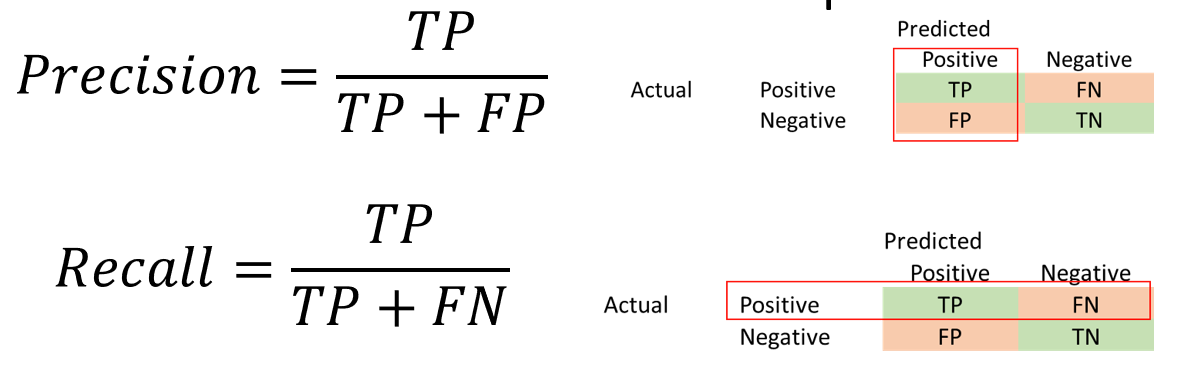    
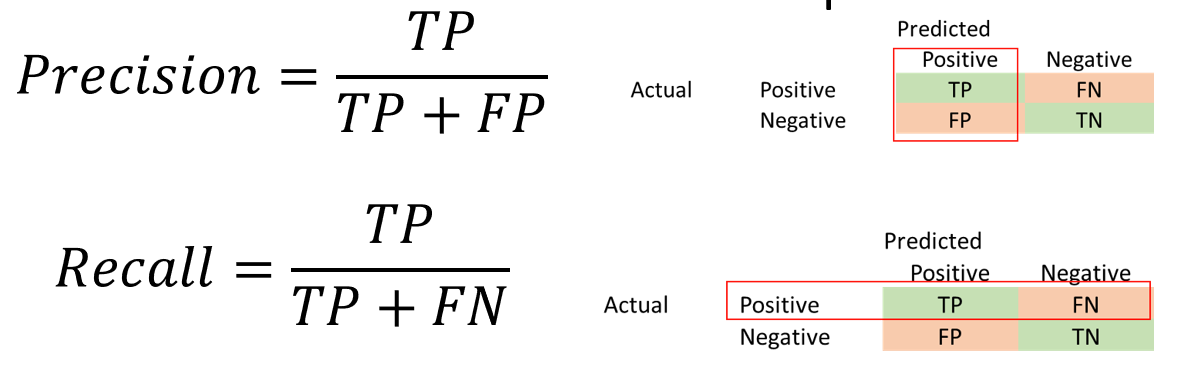  

We can look at our options using the ROC curve, but the ROC curve uses False Positive and True Positive rates (not precision and recall).  Roughly, we want a high True Positive rate (that minimizes FNs) and are okay if the False Positive rate goes up.  

Recall the formulae for TP and FP rates:  
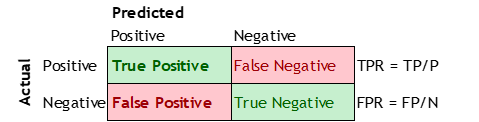

**This means we can play around with the threshold that decides what is marked as 'yes'.  Feel free to reduce this threshold on the next cell, and see if it helps you get better recall for category 1 (that may reduce accuracy, but that is okay).**   
## Adjusting the threshold  
Let us lower the threshold to 0.4 and see what happens to our confusion matrix, and if we can lower our total cost.



In [ ]:
# Set threshold for identifying class 1
threshold = 0.4

# Create predictions.  Note that predictions give us probabilities, not classes!
pred_prob = model_xgb.predict_proba(X_test)

# We drop the probabilities for class 0, and keep just the second column
pred_prob = pred_prob[:,1]

# Convert probabilities to 1s and 0s based on threshold
pred = (pred_prob>threshold).astype(int)

# confusion matrix
cm = confusion_matrix(y_test, pred)
print ("Confusion Matrix : \n", cm)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

# accuracy score of the model
print('Test accuracy = ', accuracy_score(y_test, pred))
print(classification_report(y_true = y_test, y_pred = pred))

So we see that recall has gone up to 90% from a lower number earlier.

In [ ]:
# See what predicted probabilities look like
pred_prob

In [ ]:
pred

In [ ]:
# pred_prob = pred_prob[:,1]

**Calculating Total Cost in Dollars**  
We know that the cost of a False Positive is \\$90, whereas the cost of a False Negative is \\$1500.  

Let us calculate the total cost based on our confusion matrix.

In [ ]:
False_Positive_Cost = 90 * cm[0,1]
False_Negative_Cost = 1500 * cm[1,0]

In [ ]:
Total_cost = False_Positive_Cost + False_Negative_Cost
Total_cost

Now you can see how you can play around with the threshold and change your total cost.  In fact, you could create a loop to go through many possibiities of thresholds and find out the optimal threshold that leads to the minimum cost.  1m

## AUC and ROC calculation

In [ ]:
# AUC calculation
from sklearn import metrics
metrics.roc_auc_score(y_test, pred_prob)

In [ ]:
# Source for code below: https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_prob)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize = (9,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
pd.DataFrame({'TPR': tpr, 'FPR': fpr, 'Threshold': thresholds}).sort_values(by = ['Threshold']).reset_index(drop=True)

In [ ]:
# Save to Excel, just easier to see there.  No need to do this if you don't want to.
pd.DataFrame({'TPR': tpr, 'FPR': fpr, 'Threshold': thresholds}).sort_values(by = ['Threshold']).reset_index(drop=True).to_excel('temp.xlsx')

## What else?

At this point, we can experiment with the threshold to determine the lowest cost.  We will find it is related to our precision and recall calculations.  Hopefully, we can make an actionable recommendation to the Big Banks Board, and they will hire us for the job!

## Try a different model?

We only tried XGBoost, but we can try any other model that we learned.  We can also try to build a neural network for the prediction of customer disputes.  Maybe those give us better results.

Below we try logistic regression.

In [ ]:
model = sm.Logit(y_train, X_train).fit(method='bfgs')
model.summary()

### Predict test set and evaluate  

**You can play with the threshold to get the right True Positive rate you desire!  The default generally is 0.50 but you can change it to lower values - eg, 0.2**   

In [ ]:

# Set threshold for identifying class 1
threshold = 0.20

In [ ]:
# Create predictions.  Note that predictions give us probabilities, not classes!
pred_prob = model.predict(X_test)

# Convert probabilities to 1s and 0s based on threshold
pred = (pred_prob>threshold).astype(int)
 
# confusion matrix
cm = confusion_matrix(y_test, pred)
print ("Confusion Matrix : \n", cm)
 
# accuracy score of the model
print('Test accuracy = ', accuracy_score(y_test, pred))

In [ ]:
cm = confusion_matrix(y_test, pred)
pd.DataFrame(cm, columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])

In [ ]:
print(classification_report(y_true = y_test, y_pred = pred))

In [ ]:
# See what predicted probabilities look like
pred_prob

In [ ]:
# A histogram of probabilities.  Why not?
pred_prob.hist(bins=40)

### AUC and ROC calculation

In [ ]:
# AUC calculation
metrics.roc_auc_score(y_test, pred_prob)

In [ ]:
# Source for code below: https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_prob)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize = (9,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()